In [1]:
import os
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm # 반복문의 진행상황 확인하는 모듈
import time
from scipy.spatial import distance

# 경고끄기 (option)
import warnings
warnings.filterwarnings('ignore')

In [2]:
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"

IMAGE_SHAPE = (224, 224)

layer = hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
model = tf.keras.Sequential([layer])
model.summary()

Metal device set to: Apple M1 Pro


2022-09-06 14:52:03.120980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-06 14:52:03.121092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
Total params: 4,226,432
Trainable params: 0
Non-trainable params: 4,226,432
_________________________________________________________________


In [3]:
model.build([None, 244, 244, 3]) # input shape 정의

model_name = model_url.split('/')[4] + '_' + model_url.split('/')[5]
model_name = 'r50x1_finetuned_costomer_goods'
# 모델이름이 제대로 안나오면 model_name = '모델명'으로 수정해주세요~

In [4]:
category = 'car'
image_path = f"../crops/{category}/"
output_path = f"../vector_frame/{category}/"
if not category in os.listdir(output_path[:-4]): # vector_frame에 카테고리 폴더 없으면 생성
    os.mkdir(f"../vector_frame/{category}" )

In [5]:
def extract(file):
    file = Image.open(file).convert('RGB').resize(IMAGE_SHAPE)
    file = np.array(file)/255.0 # 정규화

    embedding = model.predict(file[np.newaxis, ...])
    feature_np = np.array(embedding)
    flattened_feature = feature_np.flatten()

    return flattened_feature

In [6]:
extract('test_car.png')

2022-09-06 14:52:05.268269: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-06 14:52:05.373122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


array([-0.3479102 , -0.32233146, -0.09002505, ..., -0.        ,
        0.5919215 , -0.37499073], dtype=float32)

In [7]:
def make_dataframe(category=category, model_name=model_name):
    global image_path
    global output_path
    file_list = os.listdir(image_path)
    file_list_img = [file for file in file_list if file.endswith(".png") or file.endswith(".jpeg") or file.endswith(".jpg")]
    tmp_df = pd.DataFrame()
    for i, img in enumerate(tqdm(file_list_img)):
        output = extract(image_path+'/'+img)
        tmp_df = tmp_df.append({'filename':img, 'output':output}, ignore_index=True)

    np.save(output_path+f'{category}_filename({model_name}).npy', tmp_df['filename'])
    np.save(output_path+f'{category}_output({model_name}).npy', tmp_df['output']) # np.array배열 형태로 나중에 불러오기 위해 따로 저장

In [8]:
make_dataframe()

  0%|          | 0/1762 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


In [9]:
def get_dataframe(category=category, model_name=model_name):
    global output_path    
    tmp_filename = np.load(output_path+f'{category}_filename({model_name}).npy', allow_pickle=True)
    tmp_output = np.load(output_path+f'{category}_output({model_name}).npy', allow_pickle=True)
    df = pd.DataFrame({'filename':tmp_filename, 'output':tmp_output})
    return df

In [10]:
get_dataframe()

filename  \
0      F2022033100002479-1.jpg   
1      F2022042700001500-1.jpg   
2     F2022070200001394-12.jpg   
3      F2022040700003124-1.jpg   
4      F2022072800003477-1.jpg   
...                        ...   
1757   F2022080600001286-1.jpg   
1758   V0000298H04140004-1.jpg   
1759   F2022051200000368-1.jpg   
1760   F2022062200001366-1.jpg   
1761   F2022041900003073-1.jpg   

                                                 output  
0     [0.017264511, -0.0, -0.0, -0.34863773, 0.85763...  
1     [-0.31642628, -0.09800617, 0.36621258, -0.0, 0...  
2     [0.18880494, -0.28243655, -0.07300966, -0.0, 0...  
3     [-0.26218235, -0.37065387, -0.079708315, -0.36...  
4     [-0.35453114, -0.37485015, -0.37447226, -0.198...  
...                                                 ...  
1757  [-0.03889899, 0.075777136, -0.2531035, -0.2131...  
1758  [0.013468781, -0.10026822, -0.37088206, -0.060...  
1759  [-0.004289568, -0.37430456, -0.34097663, -0.07...  
1760  [0.09359228, -0.092524335, 0.2687886, -0.14984...  
1761  [-0.37367263, -0.3694195, -0.3496522, -0.37466...  

[1762 rows x 2 columns]

In [11]:
def get_cos_sim(file, category=category, metric='cosine'):
    before_time = time.time()
    file2vec = extract(file) # 이미지 벡터화
    df = get_dataframe() # 데이터프레임 가져오기
    df = df.append({'filename':file, 'output':file2vec}, ignore_index=True)
    
    cos_sim_array = np.zeros((len(df)))
    for i in range(0, len(df)):
        cos_sim_array[i] = distance.cdist([file2vec] , [df.iloc[i, 1]], metric)[0] # 벡터화된 이미지 기준
    df['cos_sim']=cos_sim_array
    after_time = time.time()
    runtime = after_time-before_time
    return df, runtime # 런타임 비교용

In [12]:
def show_sim(input_file):
    global image_path
    global output_path
    cos_sim_df, runtime = get_cos_sim(input_file)
    df_top_sim = cos_sim_df.sort_values(by='cos_sim')[:15]

    # 그래프 그리는 부분은 서비스 시 생략 가능
    f, ax = plt.subplots(3, 5, figsize=(40, 20))

    for i in range(len(df_top_sim)):
        if i == 0: 
            tmp_img = Image.open(df_top_sim.iloc[i, 0]).convert('RGB')
            title = f'Original \n{df_top_sim.iloc[i, 0]}'
        else : 
            tmp_img = Image.open(image_path+'/'+df_top_sim.iloc[i, 0]).convert('RGB')
            title = f'similarity no.{i} \n{df_top_sim.iloc[i, 0]}'

        sim = f'cos : {df_top_sim.iloc[i, 2]:.3f}' 
        ax[i//5][i%5].imshow(tmp_img, aspect='auto')
        ax[i//5][i%5].set_title(title, pad=20, size=25) # 5열짜리 표를 만드는 것이므로 단순히 5로 나눈 나머지와 몫을 사용한 것임
        ax[i//5][i%5].annotate(sim, (0,10), fontsize=18, color='red')
    
    print(f'소요시간 : {runtime:.3f}')
    plt.show()

In [13]:
def show_sim_threshold(input_file, threshold):
    global image_path
    global output_path
    cos_sim_df, runtime = get_cos_sim(input_file)
    df_top_sim = cos_sim_df[cos_sim_df.cos_sim < threshold].sort_values(by='cos_sim')[:30]
    # 그래프 그리는 부분은 서비스 시 생략 가능
    if len(df_top_sim) <= 10:
        f, ax = plt.subplots(2, 5, figsize=(40, 20))
    elif len(df_top_sim) <=15:
        f, ax = plt.subplots(3, 5, figsize=(40, 30))
    elif len(df_top_sim) <=20:
        f, ax = plt.subplots(4, 5, figsize=(40, 40))
    elif len(df_top_sim) <=25:
        f, ax = plt.subplots(5, 5, figsize=(40, 45))
    else:
        f, ax = plt.subplots(6, 5, figsize=(40, 50))

    for i in range(len(df_top_sim)):
        if i == 0: 
            tmp_img = Image.open(df_top_sim.iloc[i, 0]).convert('RGB')
            title = f'Original \n{df_top_sim.iloc[i, 0]}'
        else : 
            tmp_img = Image.open(image_path+'/'+df_top_sim.iloc[i, 0]).convert('RGB')
            title = f'similarity no.{i} \n{df_top_sim.iloc[i, 0]}'

        sim = f'cos : {df_top_sim.iloc[i, 2]:.3f}' 
        ax[i//5][i%5].imshow(tmp_img, aspect='auto')
        ax[i//5][i%5].set_title(title, pad=20, size=25) # 5열짜리 표를 만드는 것이므로 단순히 5로 나눈 나머지와 몫을 사용한 것임
        ax[i//5][i%5].annotate(sim, (0,10), fontsize=18, color='red')
    
    print(f'소요시간 : {runtime:.3f}')
    plt.show()

1/1 [==============================] - 0s 20ms/step
소요시간 : 0.090


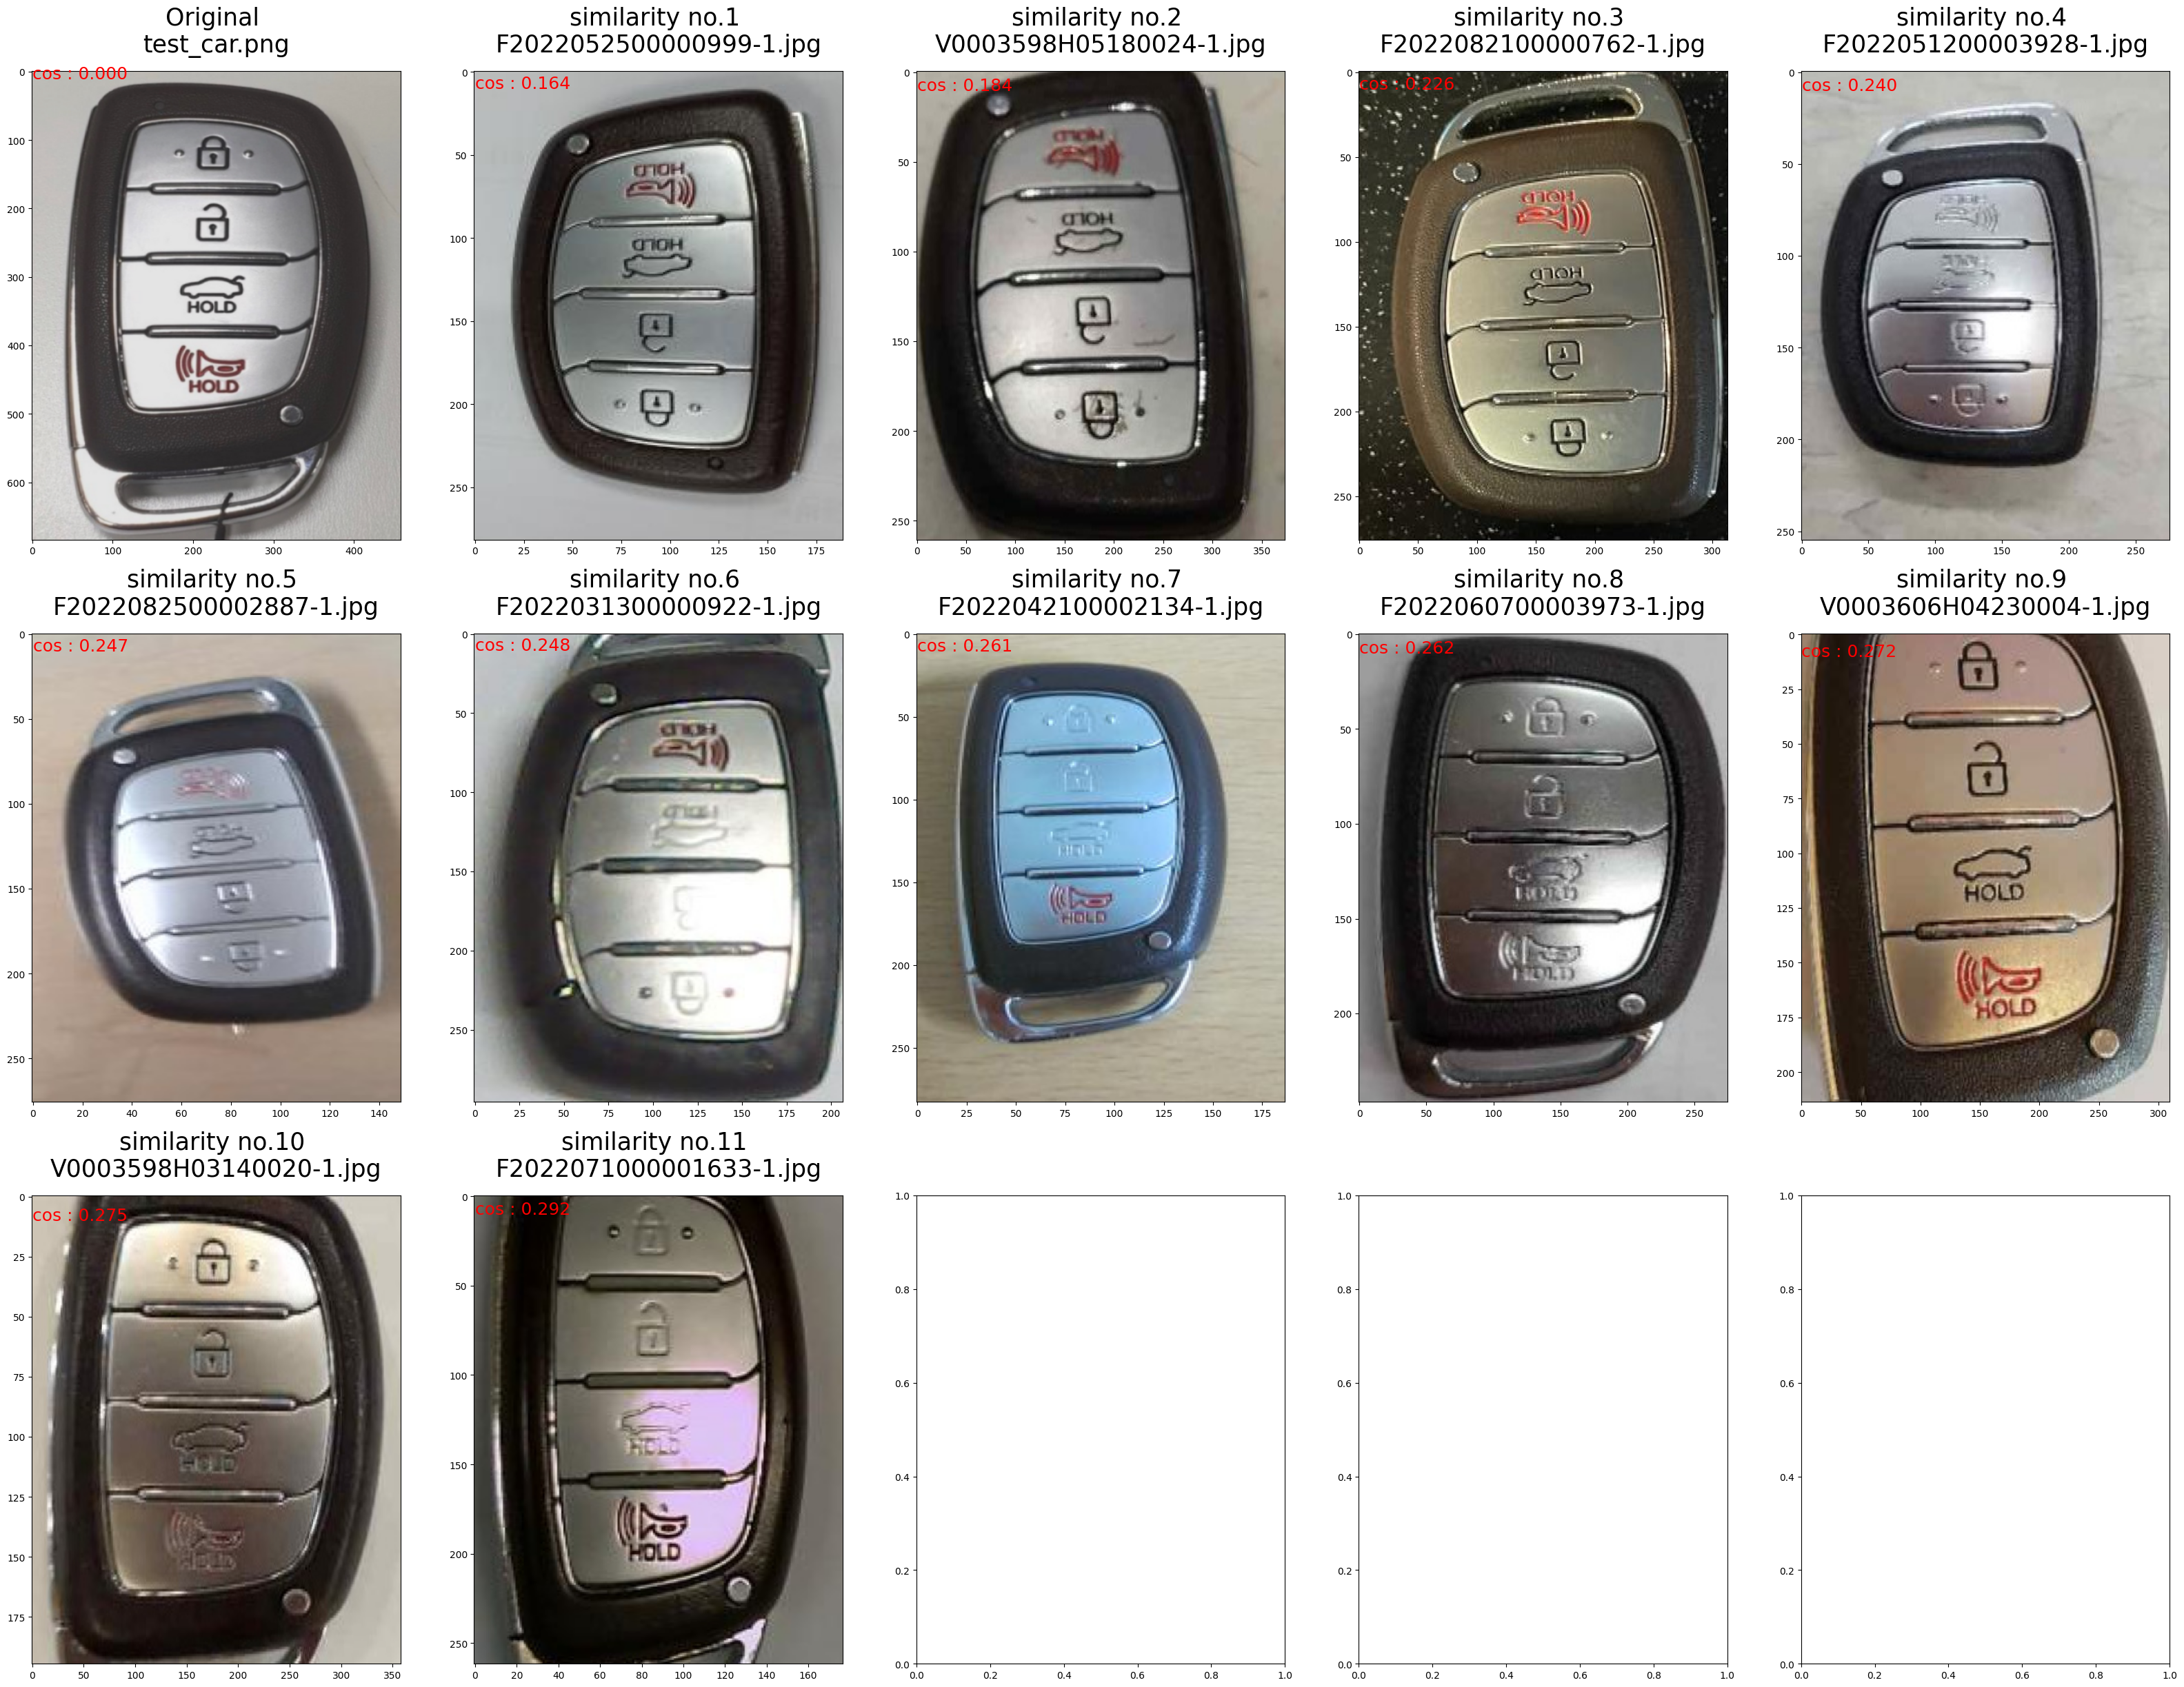

In [14]:
input_file = 'test_car.png'
threshold = 0.3
show_sim_threshold(input_file, threshold=threshold)

In [15]:
def get_runtime(input_file=input_file, category=category):
    runtime_list = list()
    for i in range(100):
        df, runtime = get_cos_sim(input_file, category)
        runtime_list.append(runtime)
    runtime_mean = np.mean(runtime_list)
    print(f'100회 평균 소요시간 : {runtime_mean:.3f}초')

get_runtime()

1/1 [==============================] - 0s 19ms/step
100회 평균 소요시간 : 0.086초
